# Create step-lagged variants of 3-hour means from preceding records
- For 3-hour means of variables `SWC`, `TS` and `PRECIP` calculated in step `33.2`
- Step-lagged means that the means are lagged, however, the lag is not applied continuously (1 record, 2 records, 3 records, ...) but in steps (6 records, 12, 18, 24)
- 6 records (half-hourly data) correspond to 3 hours
- Implementation follows the description in Feigenwinter et al. (2023):
```“We created aggregated and lagged versions of these three variables: The running mean over 3 h before the respective timestamp (mean3h) was calculated as well as lagged running means over 3 h, which started 6, 9, and 12 h before and ended 3, 6, and 9 h before the corresponding timestamp, respectively (...).”```

**Reference**:  
Feigenwinter, I., Hörtnagl, L., & Buchmann, N. (2023). N2O and CH4 fluxes from intensively managed grassland: The importance of biological and environmental drivers vs. management. Science of The Total Environment, 903, 166389. https://doi.org/10.1016/j.scitotenv.2023.166389

# Imports

In [1]:
import importlib.metadata
import pandas as pd
import warnings
import datetime as dt
from datetime import datetime
from pathlib import Path

from diive.core.io.files import save_parquet, load_parquet
from diive.pkgs.createvar.laggedvariants import lagged_variants
# pd.options.display.width = None
# pd.options.display.max_columns = None
pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 3000)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.85.5


# Load data

In [2]:
SOURCEDIR = r""
FILENAME = r"33.3_CH-CHA_IRGA+QCL+LGR+M10+MGMT_Level-1_eddypro_fluxnet_2005-2024.parquet"
FILEPATH = Path(SOURCEDIR) / FILENAME
print(f"Data will be loaded from the following file:\n{FILEPATH}")
maindf = load_parquet(filepath=FILEPATH)
maindf

Data will be loaded from the following file:
33.3_CH-CHA_IRGA+QCL+LGR+M10+MGMT_Level-1_eddypro_fluxnet_2005-2024.parquet
Loaded .parquet file 33.3_CH-CHA_IRGA+QCL+LGR+M10+MGMT_Level-1_eddypro_fluxnet_2005-2024.parquet (0.433 seconds).
    --> Detected time resolution of <30 * Minutes> / 30min 


,AIR_CP,AIR_DENSITY,AIR_MV,AIR_RHO_CP,AOA_METHOD,AXES_ROTATION_METHOD,BADM_HEIGHTC,BADM_INSTPAIR_EASTWARD_SEP_GA_CH4,BADM_INSTPAIR_EASTWARD_SEP_GA_CO2,BADM_INSTPAIR_EASTWARD_SEP_GA_H2O,BADM_INSTPAIR_EASTWARD_SEP_GA_N2O,BADM_INSTPAIR_HEIGHT_SEP_GA_CH4,BADM_INSTPAIR_HEIGHT_SEP_GA_CO2,BADM_INSTPAIR_HEIGHT_SEP_GA_H2O,BADM_INSTPAIR_HEIGHT_SEP_GA_N2O,BADM_INSTPAIR_NORTHWARD_SEP_GA_CH4,BADM_INSTPAIR_NORTHWARD_SEP_GA_CO2,BADM_INSTPAIR_NORTHWARD_SEP_GA_H2O,BADM_INSTPAIR_NORTHWARD_SEP_GA_N2O,BADM_INST_AVERAGING_INT,BADM_INST_GA_CP_TUBE_FLOW_RATE_GA_CH4,BADM_INST_GA_CP_TUBE_FLOW_RATE_GA_H2O,BADM_INST_GA_CP_TUBE_FLOW_RATE_GA_N2O,BADM_INST_GA_CP_TUBE_IN_DIAM_GA_CH4,BADM_INST_GA_CP_TUBE_IN_DIAM_GA_H2O,BADM_INST_GA_CP_TUBE_IN_DIAM_GA_N2O,BADM_INST_GA_CP_TUBE_LENGTH_GA_CH4,BADM_INST_GA_CP_TUBE_LENGTH_GA_H2O,BADM_INST_GA_CP_TUBE_LENGTH_GA_N2O,BADM_INST_HEIGHT_SA,BADM_INST_SAMPLING_INT,BADM_LOCATION_ELEV,BADM_LOCATION_LAT,BADM_LOCATION_LONG,BADM_SA_OFFSET_NORTH,BOWEN,BURBA_METHOD,CH4,CH4_ABSLIM_NREX,CH4_DIAG_NREX,CH4_KID,CH4_LGD,CH4_MEAS_KUR,CH4_MEAS_MEDIAN,CH4_MEAS_N2O_MEAS_COV,CH4_MEAS_P25,CH4_MEAS_P75,CH4_MEAS_SIGMA,CH4_MEAS_SKW,CH4_MEAS_TYPE,CH4_MIXING_RATIO,CH4_MOLAR_DENSITY,CH4_NR,CH4_NUM_SPIKES,CH4_SPIKE_NREX,CH4_TLAG_ACTUAL,CH4_TLAG_MAX,CH4_TLAG_MIN,CH4_TLAG_NOMINAL,CH4_TLAG_USED,CH4_VM97_TEST,CH4_ZCD,CO2,CO2_ABSLIM_NREX,CO2_DIAG_NREX,CO2_KID,CO2_LGD,CO2_MEAS_H2O_MEAS_COV,CO2_MEAS_KUR,CO2_MEAS_MEDIAN,CO2_MEAS_P25,CO2_MEAS_P75,CO2_MEAS_SIGMA,CO2_MEAS_SKW,CO2_MEAS_TYPE,CO2_MIXING_RATIO,CO2_MOLAR_DENSITY,CO2_NR,CO2_NUM_SPIKES,CO2_SPIKE_NREX,CO2_TLAG_ACTUAL,CO2_TLAG_MAX,CO2_TLAG_MIN,CO2_TLAG_NOMINAL,CO2_TLAG_USED,CO2_VM97_TEST,CO2_ZCD,CUSTOM_AGC_MEAN,CUSTOM_AIR_P_MEAN,CUSTOM_CH4_MEAN,CUSTOM_COOLER_V_MEAN,CUSTOM_DATA_SIZE_IRGA75_MEAN,CUSTOM_DATA_SIZE_LGR_MEAN,CUSTOM_DATA_SIZE_QCL_MEAN,CUSTOM_DUMMY_MEAN,CUSTOM_FAST_T_MEAN,CUSTOM_FILTER_NR,CUSTOM_FILTER_NREX,CUSTOM_FIT_FLAG_LGR_MEAN,CUSTOM_GA_DIAG_CODE_IRGA75_MEAN,CUSTOM_MIRROR_RINGDOWNTIME_LGR_MEAN,CUSTOM_N2O_MEAN,CUSTOM_STATUS_CODE_IRGA75_MEAN,CUSTOM_STATUS_CODE_LGR_MEAN,CUSTOM_STATUS_CODE_QCL_MEAN,CUSTOM_STATUS_QCL_MEAN,CUSTOM_STATUS_WORD_QCL_MEAN,CUSTOM_T_UNKNOWN_MEAN,CUSTOM_VICI_MEAN,DENTRENDING_TIME_CONSTANT,DETRENDING_METHOD,DISPLACEMENT_HEIGHT,DOY_END,DOY_START,DRYAIR_DENSITY,DRYAIR_MV,DRYAIR_PARTIAL_PRESSURE,ET,ET_CORRDIFF,ET_RANDUNC_HF,ET_SCF,ET_SSITC_TEST,ET_STAGE1,ET_STAGE2,ET_UNCORR,EXPECT_NR,FC,FCH4,FCH4_CORRDIFF,FCH4_NR,FCH4_NSR,FCH4_RANDUNC_HF,FCH4_SCF,FCH4_SS,FCH4_SSITC_TEST,FCH4_SS_TEST,FCH4_STAGE1,FCH4_STAGE2,FCH4_UNCORR,FCH4_VADV,FC_CORRDIFF,FC_NR,FC_NSR,FC_RANDUNC_HF,FC_SCF,FC_SS,FC_SSITC_TEST,FC_SS_TEST,FC_STAGE1,FC_STAGE2,FC_UNCORR,FC_VADV,FETCH_10,FETCH_30,FETCH_50,FETCH_70,FETCH_80,FETCH_90,FETCH_MAX,FETCH_OFFSET,FH2O,FH2O_CORRDIFF,FH2O_NSR,FH2O_RANDUNC_HF,FH2O_SCF,FH2O_SS,FH2O_SSITC_TEST,FH2O_SS_TEST,FH2O_STAGE1,FH2O_STAGE2,FH2O_UNCORR,FH2O_VADV,FILE_NR,FILE_TIME_DURATION,FLAG_PA_GF1_0.9_1_ISFILLED,FLAG_PPFD_IN_T1_2_2_ISFILLED,FLAG_PREC_RAIN_TOT_GF1_0.5_1_FLUXNET_ISFILLED,FLAG_PREC_RAIN_TOT_GF1_0.5_1_ISFILLED,FLAG_RH_T1_2_1_ISFILLED,FLAG_SWC_GF1_0.15_1_gfXG_ISFILLED,FLAG_SW_IN_T1_2_1_ISFILLED,FLAG_TA_T1_2_1_ISFILLED,FLAG_TS_GF1_0.04_1_gfXG_ISFILLED,FLAG_TS_GF1_0.15_1_gfXG_ISFILLED,FLAG_TS_GF1_0.4_1_gfXG_ISFILLED,FLAG_VPD_T1_2_1_ISFILLED,FN2O,FN2O_CORRDIFF,FN2O_NR,FN2O_NSR,FN2O_RANDUNC_HF,FN2O_SCF,FN2O_SS,FN2O_SSITC_TEST,FN2O_SS_TEST,FN2O_STAGE1,FN2O_STAGE2,FN2O_UNCORR,FN2O_VADV,FOOTPRINT_MODEL,H,H2O,H2O_ABSLIM_NREX,H2O_DIAG_NREX,H2O_KID,H2O_LGD,H2O_MEAS_CH4_MEAS_COV,H2O_MEAS_KUR,H2O_MEAS_MEDIAN,H2O_MEAS_N2O_MEAS_COV,H2O_MEAS_P25,H2O_MEAS_P75,H2O_MEAS_SIGMA,H2O_MEAS_SKW,H2O_MEAS_TYPE,H2O_MIXING_RATIO,H2O_MOLAR_DENSITY,H2O_NR,H2O_NUM_SPIKES,H2O_SPIKE_NREX,H2O_TLAG_ACTUAL,H2O_TLAG_MAX,H2O_TLAG_MIN,H2O_TLAG_NOMINAL,H2O_TLAG_USED,H2O_VM97_TEST,H2O_ZCD,HPATH_GA_CH4,HPATH_GA_CO2,HPATH_GA_H2O,HPATH_GA_N2O,HPATH_SA,H_CORRDIFF,H_NR,H_NSR,H_RANDUNC_HF,H_SCF,H_SS,H_SSITC_TEST,H_SS_TEST,H_STAGE1,H_STAGE2,H_UNCORR,INST_LI7200_AGC_OR_RSSI,INST_LI7500_AGC_OR_RSSI,LE,LE_CORRDIFF,LE_NR

# Find aggregated variable names

In [3]:
measured = ['SWC_GF1_0.15_1_gfXG', 'TS_GF1_0.04_1_gfXG', 'TS_GF1_0.15_1_gfXG', 'TS_GF1_0.4_1_gfXG', 'PREC_RAIN_TOT_GF1_0.5_1']
lagged = [f"{m}_MEAN3H" for m in measured]
lagged

['SWC_GF1_0.15_1_gfXG_MEAN3H',
 'TS_GF1_0.04_1_gfXG_MEAN3H',
 'TS_GF1_0.15_1_gfXG_MEAN3H',
 'TS_GF1_0.4_1_gfXG_MEAN3H',
 'PREC_RAIN_TOT_GF1_0.5_1_MEAN3H']

# Make subset

In [4]:
subset = maindf[lagged].copy()
subset

,SWC_GF1_0.15_1_gfXG_MEAN3H,TS_GF1_0.04_1_gfXG_MEAN3H,TS_GF1_0.15_1_gfXG_MEAN3H,TS_GF1_0.4_1_gfXG_MEAN3H,PREC_RAIN_TOT_GF1_0.5_1_MEAN3H
TIMESTAMP_MIDDLE,,,,,
2005-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN
2005-01-01 00:45:00,NaN,NaN,NaN,NaN,NaN
2005-01-01 01:15:00,NaN,NaN,NaN,NaN,NaN
2005-01-01 01:45:00,NaN,NaN,NaN,NaN,NaN
2005-01-01 02:15:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2024-12-31 21:45:00,52.381843,3.543930,4.427296,5.526472,0.0
2024-12-31 22:15:00,52.423854,3.526228,4.431297,5.526472,0.0
2024-12-31 22:45:00,52.496681,3.502270,4.434965,5.525231,0.0


# Create step-lagged variants
- Lag variables by 3, 6, 9 and 12 hours (corresponds to 6, 12, 18 and 24 records in the data, respectively)

In [5]:
res = lagged_variants(df=subset, 
                      lag=[-24, -6],  # for 30MIN data, 24 records = 12 hours 
                      stepsize=6,
                      exclude_cols=None)
res

,SWC_GF1_0.15_1_gfXG_MEAN3H,TS_GF1_0.04_1_gfXG_MEAN3H,TS_GF1_0.15_1_gfXG_MEAN3H,TS_GF1_0.4_1_gfXG_MEAN3H,PREC_RAIN_TOT_GF1_0.5_1_MEAN3H,.SWC_GF1_0.15_1_gfXG_MEAN3H-24,.SWC_GF1_0.15_1_gfXG_MEAN3H-18,.SWC_GF1_0.15_1_gfXG_MEAN3H-12,.SWC_GF1_0.15_1_gfXG_MEAN3H-6,.TS_GF1_0.04_1_gfXG_MEAN3H-24,.TS_GF1_0.04_1_gfXG_MEAN3H-18,.TS_GF1_0.04_1_gfXG_MEAN3H-12,.TS_GF1_0.04_1_gfXG_MEAN3H-6,.TS_GF1_0.15_1_gfXG_MEAN3H-24,.TS_GF1_0.15_1_gfXG_MEAN3H-18,.TS_GF1_0.15_1_gfXG_MEAN3H-12,.TS_GF1_0.15_1_gfXG_MEAN3H-6,.TS_GF1_0.4_1_gfXG_MEAN3H-24,.TS_GF1_0.4_1_gfXG_MEAN3H-18,.TS_GF1_0.4_1_gfXG_MEAN3H-12,.TS_GF1_0.4_1_gfXG_MEAN3H-6,.PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-24,.PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-18,.PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-12,.PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-6
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,,,,,,,
2005-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-01 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-01 01:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-01 01:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-01 02:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 21:45:00,52.381843,3.543930,4.427296,5.526472,0.0,52.226689,52.226300,52.229004,52.216796,3.115260,3.150402,3.458828,3.660897,4.385967,4.347764,4.335667,4.380746,5.578488,5.563245,5.544399,5.532447,0.0,0.0,0.0,0.0
2024-12-31 22:15:00,52.423854,3.526228,4.431297,5.526472,0.0,52.224528,52.227986,52.227858,52.214211,3.103440,3.187638,3.522570,3.643396,4.379524,4.342880,4.338551,4.390522,5.576117,5.560310,5.542933,5.530305,0.0,0.0,0.0,0.0
2024-12-31 22:45:00,52.496681,3.502270,4.434965,5.525231,0.0,52.222456,52.229837,52.226640,52.209876,3.095339,3.230037,3.578745,3.624025,4.372636,4.339440,4.343767,4.399743,5.573519,5.556698,5.541354,5.529065,0.0,0.0,0.0,0.0


# Add new columns to main data

In [6]:
newcols = [c for c in res.columns if c not in maindf.columns]
newcols

['.SWC_GF1_0.15_1_gfXG_MEAN3H-24',
 '.SWC_GF1_0.15_1_gfXG_MEAN3H-18',
 '.SWC_GF1_0.15_1_gfXG_MEAN3H-12',
 '.SWC_GF1_0.15_1_gfXG_MEAN3H-6',
 '.TS_GF1_0.04_1_gfXG_MEAN3H-24',
 '.TS_GF1_0.04_1_gfXG_MEAN3H-18',
 '.TS_GF1_0.04_1_gfXG_MEAN3H-12',
 '.TS_GF1_0.04_1_gfXG_MEAN3H-6',
 '.TS_GF1_0.15_1_gfXG_MEAN3H-24',
 '.TS_GF1_0.15_1_gfXG_MEAN3H-18',
 '.TS_GF1_0.15_1_gfXG_MEAN3H-12',
 '.TS_GF1_0.15_1_gfXG_MEAN3H-6',
 '.TS_GF1_0.4_1_gfXG_MEAN3H-24',
 '.TS_GF1_0.4_1_gfXG_MEAN3H-18',
 '.TS_GF1_0.4_1_gfXG_MEAN3H-12',
 '.TS_GF1_0.4_1_gfXG_MEAN3H-6',
 '.PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-24',
 '.PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-18',
 '.PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-12',
 '.PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-6']

In [7]:
df = pd.concat([maindf, res[newcols]], axis=1)
df = df.reindex(sorted(df.columns), axis=1)
df

,.PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-12,.PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-18,.PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-24,.PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-6,.SWC_GF1_0.15_1_gfXG_MEAN3H-12,.SWC_GF1_0.15_1_gfXG_MEAN3H-18,.SWC_GF1_0.15_1_gfXG_MEAN3H-24,.SWC_GF1_0.15_1_gfXG_MEAN3H-6,.TS_GF1_0.04_1_gfXG_MEAN3H-12,.TS_GF1_0.04_1_gfXG_MEAN3H-18,.TS_GF1_0.04_1_gfXG_MEAN3H-24,.TS_GF1_0.04_1_gfXG_MEAN3H-6,.TS_GF1_0.15_1_gfXG_MEAN3H-12,.TS_GF1_0.15_1_gfXG_MEAN3H-18,.TS_GF1_0.15_1_gfXG_MEAN3H-24,.TS_GF1_0.15_1_gfXG_MEAN3H-6,.TS_GF1_0.4_1_gfXG_MEAN3H-12,.TS_GF1_0.4_1_gfXG_MEAN3H-18,.TS_GF1_0.4_1_gfXG_MEAN3H-24,.TS_GF1_0.4_1_gfXG_MEAN3H-6,AIR_CP,AIR_DENSITY,AIR_MV,AIR_RHO_CP,AOA_METHOD,AXES_ROTATION_METHOD,BADM_HEIGHTC,BADM_INSTPAIR_EASTWARD_SEP_GA_CH4,BADM_INSTPAIR_EASTWARD_SEP_GA_CO2,BADM_INSTPAIR_EASTWARD_SEP_GA_H2O,BADM_INSTPAIR_EASTWARD_SEP_GA_N2O,BADM_INSTPAIR_HEIGHT_SEP_GA_CH4,BADM_INSTPAIR_HEIGHT_SEP_GA_CO2,BADM_INSTPAIR_HEIGHT_SEP_GA_H2O,BADM_INSTPAIR_HEIGHT_SEP_GA_N2O,BADM_INSTPAIR_NORTHWARD_SEP_GA_CH4,BADM_INSTPAIR_NORTHWARD_SEP_GA_CO2,BADM_INSTPAIR_NORTHWARD_SEP_GA_H2O,BADM_INSTPAIR_NORTHWARD_SEP_GA_N2O,BADM_INST_AVERAGING_INT,BADM_INST_GA_CP_TUBE_FLOW_RATE_GA_CH4,BADM_INST_GA_CP_TUBE_FLOW_RATE_GA_H2O,BADM_INST_GA_CP_TUBE_FLOW_RATE_GA_N2O,BADM_INST_GA_CP_TUBE_IN_DIAM_GA_CH4,BADM_INST_GA_CP_TUBE_IN_DIAM_GA_H2O,BADM_INST_GA_CP_TUBE_IN_DIAM_GA_N2O,BADM_INST_GA_CP_TUBE_LENGTH_GA_CH4,BADM_INST_GA_CP_TUBE_LENGTH_GA_H2O,BADM_INST_GA_CP_TUBE_LENGTH_GA_N2O,BADM_INST_HEIGHT_SA,BADM_INST_SAMPLING_INT,BADM_LOCATION_ELEV,BADM_LOCATION_LAT,BADM_LOCATION_LONG,BADM_SA_OFFSET_NORTH,BOWEN,BURBA_METHOD,CH4,CH4_ABSLIM_NREX,CH4_DIAG_NREX,CH4_KID,CH4_LGD,CH4_MEAS_KUR,CH4_MEAS_MEDIAN,CH4_MEAS_N2O_MEAS_COV,CH4_MEAS_P25,CH4_MEAS_P75,CH4_MEAS_SIGMA,CH4_MEAS_SKW,CH4_MEAS_TYPE,CH4_MIXING_RATIO,CH4_MOLAR_DENSITY,CH4_NR,CH4_NUM_SPIKES,CH4_SPIKE_NREX,CH4_TLAG_ACTUAL,CH4_TLAG_MAX,CH4_TLAG_MIN,CH4_TLAG_NOMINAL,CH4_TLAG_USED,CH4_VM97_TEST,CH4_ZCD,CO2,CO2_ABSLIM_NREX,CO2_DIAG_NREX,CO2_KID,CO2_LGD,CO2_MEAS_H2O_MEAS_COV,CO2_MEAS_KUR,CO2_MEAS_MEDIAN,CO2_MEAS_P25,CO2_MEAS_P75,CO2_MEAS_SIGMA,CO2_MEAS_SKW,CO2_MEAS_TYPE,CO2_MIXING_RATIO,CO2_MOLAR_DENSITY,CO2_NR,CO2_NUM_SPIKES,CO2_SPIKE_NREX,CO2_TLAG_ACTUAL,CO2_TLAG_MAX,CO2_TLAG_MIN,CO2_TLAG_NOMINAL,CO2_TLAG_USED,CO2_VM97_TEST,CO2_ZCD,CUSTOM_AGC_MEAN,CUSTOM_AIR_P_MEAN,CUSTOM_CH4_MEAN,CUSTOM_COOLER_V_MEAN,CUSTOM_DATA_SIZE_IRGA75_MEAN,CUSTOM_DATA_SIZE_LGR_MEAN,CUSTOM_DATA_SIZE_QCL_MEAN,CUSTOM_DUMMY_MEAN,CUSTOM_FAST_T_MEAN,CUSTOM_FILTER_NR,CUSTOM_FILTER_NREX,CUSTOM_FIT_FLAG_LGR_MEAN,CUSTOM_GA_DIAG_CODE_IRGA75_MEAN,CUSTOM_MIRROR_RINGDOWNTIME_LGR_MEAN,CUSTOM_N2O_MEAN,CUSTOM_STATUS_CODE_IRGA75_MEAN,CUSTOM_STATUS_CODE_LGR_MEAN,CUSTOM_STATUS_CODE_QCL_MEAN,CUSTOM_STATUS_QCL_MEAN,CUSTOM_STATUS_WORD_QCL_MEAN,CUSTOM_T_UNKNOWN_MEAN,CUSTOM_VICI_MEAN,DENTRENDING_TIME_CONSTANT,DETRENDING_METHOD,DISPLACEMENT_HEIGHT,DOY_END,DOY_START,DRYAIR_DENSITY,DRYAIR_MV,DRYAIR_PARTIAL_PRESSURE,ET,ET_CORRDIFF,ET_RANDUNC_HF,ET_SCF,ET_SSITC_TEST,ET_STAGE1,ET_STAGE2,ET_UNCORR,EXPECT_NR,FC,FCH4,FCH4_CORRDIFF,FCH4_NR,FCH4_NSR,FCH4_RANDUNC_HF,FCH4_SCF,FCH4_SS,FCH4_SSITC_TEST,FCH4_SS_TEST,FCH4_STAGE1,FCH4_STAGE2,FCH4_UNCORR,FCH4_VADV,FC_CORRDIFF,FC_NR,FC_NSR,FC_RANDUNC_HF,FC_SCF,FC_SS,FC_SSITC_TEST,FC_SS_TEST,FC_STAGE1,FC_STAGE2,FC_UNCORR,FC_VADV,FETCH_10,FETCH_30,FETCH_50,FETCH_70,FETCH_80,FETCH_90,FETCH_MAX,FETCH_OFFSET,FH2O,FH2O_CORRDIFF,FH2O_NSR,FH2O_RANDUNC_HF,FH2O_SCF,FH2O_SS,FH2O_SSITC_TEST,FH2O_SS_TEST,FH2O_STAGE1,FH2O_STAGE2,FH2O_UNCORR,FH2O_VADV,FILE_NR,FILE_TIME_DURATION,FLAG_PA_GF1_0.9_1_ISFILLED,FLAG_PPFD_IN_T1_2_2_ISFILLED,FLAG_PREC_RAIN_TOT_GF1_0.5_1_FLUXNET_ISFILLED,FLAG_PREC_RAIN_TOT_GF1_0.5_1_ISFILLED,FLAG_RH_T1_2_1_ISFILLED,FLAG_SWC_GF1_0.15_1_gfXG_ISFILLED,FLAG_SW_IN_T1_2_1_ISFILLED,FLAG_TA_T1_2_1_ISFILLED,FLAG_TS_GF1_0.04_1_gfXG_ISFILLED,FLAG_TS_GF1_0.15_1_gfXG_ISFILLED,FLAG_TS_GF1_0.4_1_gfXG_ISFILLED,FLAG_VPD_T1_2_1_ISFILLED,FN2O,FN2O_CORRDIFF,FN2O_NR,FN2O_NSR,FN2O_RANDUNC_HF,FN2O_SCF,FN2O_SS,FN2O_SSITC_TEST,FN2O_SS_TEST,FN2O_STAGE1,FN2O_STAGE2,FN2O_UNC

# Plot

In [8]:
checkcols = [c for c in df.columns if "TS_GF1_0.15_1_gfXG_MEAN3H" in c]
checkcols

['.TS_GF1_0.15_1_gfXG_MEAN3H-12',
 '.TS_GF1_0.15_1_gfXG_MEAN3H-18',
 '.TS_GF1_0.15_1_gfXG_MEAN3H-24',
 '.TS_GF1_0.15_1_gfXG_MEAN3H-6',
 'TS_GF1_0.15_1_gfXG_MEAN3H']

<Axes: xlabel='TIMESTAMP_MIDDLE'>

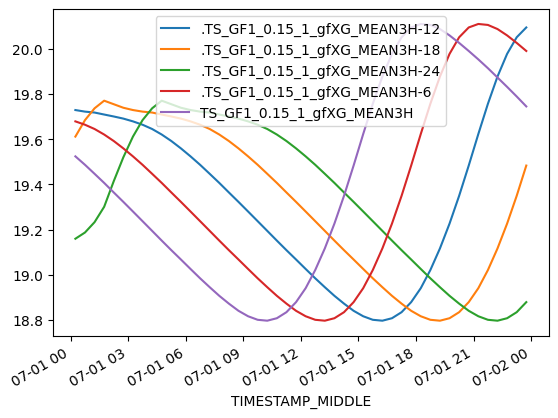

In [9]:
plotdf = df[checkcols].copy()
locs = (plotdf.index.date == dt.date(2023, 7, 1))
# locs = (plotdf.index.month == 7) & (plotdf.index.year == 2023) & (plotdf)
plotdf = plotdf[locs].copy()
plotdf.plot(x_compat=True)
# plotdf.index.date

# Save to file

In [10]:
OUTNAME = "33.5_CH-CHA_IRGA+QCL+LGR+M10+MGMT_Level-1_eddypro_fluxnet_2005-2024"
filepath = save_parquet(filename=OUTNAME, data=df)
df.to_csv(f"{OUTNAME}.csv")

Saved file 33.5_CH-CHA_IRGA+QCL+LGR+M10+MGMT_Level-1_eddypro_fluxnet_2005-2024.parquet (5.210 seconds).


# **End of notebook**.

In [11]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2025-02-04 20:36:20
